# Assignment 3: Reinforcement Learning Pipeline in Practice


*2022-2023 fall quarter, CS269 Seminar 5: Reinforcement Learning. Department of Computer Science at University of California, Los Angeles. Course Instructor: Professor Bolei ZHOU. Assignment Author: Zhenghao PENG.*

-----



> NOTE: **We only grade your assignment based on the report PDF file and python files. You can do whatever you like in this notebook! Running all cells in this jupyter notebook does not generate all reqiured figures in result.md**


(`README.md` and the intro of `assignment3.ipynb` are identical)

Welcome to the assignment 3 of our RL course!


Different from the previous assignment, this assignment requires you to finish codes mainly in python files instead of in a jupyter notebook. The provided jupyter notebook only walks you through the training and post-processing procedure based on those python files. 


This assignment is highly flexible. You are free to do hyper-parameter searching or improve your implementation by introducing new components. You are encouraged to survey materials in the internet that explain the mechanisms of these classic algorithms. As a start point, [Spinning Up](https://spinningup.openai.com/en/latest/) might be a good choice.



### Grading Scheme

We required you to finish the following tasks:

* Task 1: Implement TD3Trainer **(30/100 points)**
* Task 2: Implement PPOTrainer **(20/100 points)**
* Task 3: Implement GAILTrainer **(20/100 points)**
* Task 4: Conduct RL generalization experiments on one of the algorithms implemented **(30/100 points)**
* Task 5: Conduct RL generalization experiments on another one of the algorithms implemented **(Bonus 20 points)**
* Task 6: Conduct generalization experiments on GAIL that boosts the test performance. You can train and plug in a better PPO agent as the expert or adjust the hyper-pameters. The best agent in these experiments should has > 200 reward. **(Bonus 20 points)**




Therefore the possible maximum grade will be 140 points.


### Summary of Experiments

**Group 1: Baselines**

1. TD3 in Pendulum-v0
2. TD3 in MetaDrive-Tut-Easy-v0
3. PPO in CartPole-v0
4. PPO in MetaDrive-Tut-Easy-v0
5. GAIL in MetaDrive-Tut-Easy-v0

**Group 2: RL Generalization Experiments**

Choose one of TD3, PPO or GAIL, conduct generalization experiments (see "Training and test environments"). 


Bonus 20 points: Run generalization experiments on another algorithm that you are not chosen in above experiment. You need to train 6 agents in this case.




### Deliverables

The exported **PDF file** of the `result.md`: You will use the provided `result.md` and attach the required figures in it and then generate a PDF file. Please visit the `result.md` for details.

Compress all files in `assignment3` and prepares a **ZIP file**. No rar or other format.

You need to submit **both the zip file and the pdf file** to bruinlearn.


### File structure

You need to pay attention to the files below:

1. `train.py` - Train scripts for PPO in CartPole-v0 and MetaDrive. Please implement `train`.
4. `core/ppo_trainer.py` - PPO algorithm. Please implement `compute_action` and `compute_loss`.
5. `core/buffer.py` - Supporting data structure for PPO (GAE is implemented here). Please implement `compute_returns` for PPO.
6. `core/td3_trainer.py` - File which can be directly run to train TD3. Please implement TD3 here.
7. `assignment3.ipynb` - Useful jupyter notebook to walk you through the whole assignment. Unlike previous work, you are not required to fill anything in this notebook (but you can use it to do whatever you like). 
8. `result.md` - A **template** file for your final submission. You need to **generate a PDF file** based on it after attaching images in it. 
9. `[train|eval]_[ppo|gail|td3].py` and `[ppo|gail|td3]_generalization_[eval|train].sh` - Reference files that can be used to debug quickly or conduct formal experiments in batch.



### Training and test environments

We prepared a set of pre-defined MetaDrive environments to train your agents. 

The first is `MetaDrive-Tut-Easy-v0`, which only has one map with only a straight road.

We also prepare a set of environments for RL generalization experiments.

Concretely, we will use a training environment to train the RL agent and 
use a separate test environment `MetaDrive-Tut-Test-v0` to run the RL agent.
You can choose on of those training environments: 

* `MetaDrive-Tut-1Env-v0`
* `MetaDrive-Tut-5Env-v0`
* `MetaDrive-Tut-10Env-v0`
* `MetaDrive-Tut-20Env-v0`
* `MetaDrive-Tut-50Env-v0`
* `MetaDrive-Tut-100Env-v0`

Those training environment contain [1, 5, 10, 20, 50, 100] unique traffic scenarios, respectively. And the test environment contains 20 unique traffic scenarios which are unique to those in the training environments. 

By training a set of RL agents in different training environments and test them in the same test environment, we can examine the influence of the diversity of scenarios in the training environments. We expect to see that when using a training environment with more diverse data, the test performance of the trained agent should be improved, meaning it has better generalization ability.


**Please note that each MetaDrive can only run in single process. If you encounter any environmental error, please firstly try to restart the notebook and rerun the cell.**



### Notes

1. We use multi-processing to enable asynchronous data sampling. Therefore in many places the tensors have shape `[num_steps, num_envs, num_feat]`. This means that `num_envs` environments are running concurrently and each of them samples a fragment of trajectory with length `num_steps`. There are totally `num_steps*num_envs` transitions are generated in each training iteration.


2. Each process can only have a single MetaDrive environment. 


3. The jupyter notebook is used for tutorial and visualization. It is optional for you to use the notebook to train agents or visualize results.


### Colab supporting

Though we use multiple files to implement algorithms, we can still leverage Colab to access computing resources. 

* Step 1: Create a folder in your Google Drive root named `cs269`
* Step 2: Upload the files in `assignment3` folder such as `train_ppo.py` and the folder `core` to `cs269` folder in your Google Drive.
* Step 3: Run the last cell in Demo 1.



## Demo 1: Setup dependencies

In [ ]:
!pip install torch

# Install MetaDrive, a lightweight driving simulator
!pip install git+https://github.com/metadriverse/metadrive

# Test whether MetaDrive is properly installed. No error means the test is passed.
!python -m metadrive.examples.profile_metadrive --num-steps 100

!pip install pandas scipy seaborn tabulate pyyaml

# Update(2022-11-03): Fix pyglet compatability issue since it is updated to 2.0.0 recently.
!pip install "pyglet<2.0.0"

In [26]:
import os
try:
    
    from google.colab import drive
    drive.mount('/content/gdrive')

    DRIVE_PATH = '/content/gdrive/My\ Drive/cs269'
    DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
    if not os.path.exists(DRIVE_PYTHON_PATH):
      %mkdir $DRIVE_PATH

    ## the space in `My Drive` causes some issues,
    ## make a symlink to avoid this
    SYM_PATH = '/content/cs269'
    if not os.path.exists(SYM_PATH):
      !ln -s $DRIVE_PATH $SYM_PATH
    
    running_in_colab = True
    
    # We already mounted in our google drive.
    # Enter the foler where you put files in:
    %cd '/content/cs269'

    # Current working directory:
    !pwd

    # What files are there:
    !ls
   
    
except ModuleNotFoundError:
    running_in_colab = False
    print(
        "I guess you are running locally. If you get this message in Colab, check the files."
    )


I guess you are running locally. If you get this message in Colab, check the files.


## Demo 2: Train a TD3 agent

Spinning Up tutorial provides great explaination on TD3 algorithm:
https://spinningup.openai.com/en/latest/algorithms/td3.html

Please implement all TODOs in `core/td3_trainer.py` and `train_td3.py`.

### Demo 2.1: Train TD3 agent in Pendulum-v0

In [43]:
!python train_td3.py \
--env-id Pendulum-v0 \
--log-dir Pendulum-v0 \
--max-steps 50000 \
--start-steps 1000 \
--lr 1e-3

/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
===== TD3 Training Step 1199 =====:
  actor_loss: 8.975371360778809
  critic_loss: 0.7023715972900391
  episode_reward: -1340.9117373872293
  frame_per_second: 1705
  log_dir: Pendulum-v0
  target_q: -9.204303741455078
  total_episodes: 6
  total_steps: 1199
  total_time: 0.7031872272491455

Trainer is saved at <Pendulum-v0/td3>. Progress is saved at <Pendulum-v0/td3/progress.csv>.
===== TD3 Training Step 2199 =====:
  actor_loss: 23.481605529785156
  critic_loss: 2.774765968322754
  episode_reward: -1413.4206091929286
  frame_per_second: 585
  log_dir: Pendulum-v0
  target_q: -23.747577667236328
  total_episodes: 11
  total_steps: 2199
  total_time: 3.7550463676452637

===== TD3 Training Step 3199 =====:
  actor_loss: 37.568599700927734
  critic_loss: 21.136011123657227
  episode_reward: -1413.9495429691165
  frame_per_second: 469
  log_dir: Pendulum-v0
  target_q: -38.191856384277344
  total_episodes: 16
  total_

===== TD3 Training Step 25199 =====:
  actor_loss: 58.956642150878906
  critic_loss: 9.604110717773438
  episode_reward: -282.88338579378046
  frame_per_second: 354
  log_dir: Pendulum-v0
  target_q: -60.46382522583008
  total_episodes: 126
  total_steps: 25199
  total_time: 71.02494096755981

Trainer is saved at <Pendulum-v0/td3>. Progress is saved at <Pendulum-v0/td3/progress.csv>.
===== TD3 Training Step 26199 =====:
  actor_loss: 57.167640686035156
  critic_loss: 503.82684326171875
  episode_reward: -239.6136564775538
  frame_per_second: 353
  log_dir: Pendulum-v0
  target_q: -58.578678131103516
  total_episodes: 131
  total_steps: 26199
  total_time: 74.12963914871216

===== TD3 Training Step 27199 =====:
  actor_loss: 55.91941452026367
  critic_loss: 8.921577453613281
  episode_reward: -226.1675651789669
  frame_per_second: 352
  log_dir: Pendulum-v0
  target_q: -57.87915802001953
  total_episodes: 136
  total_steps: 27199
  total_time: 77.21979856491089

Trainer is saved at <Pen

Trainer is saved at <Pendulum-v0/td3>. Progress is saved at <Pendulum-v0/td3/progress.csv>.


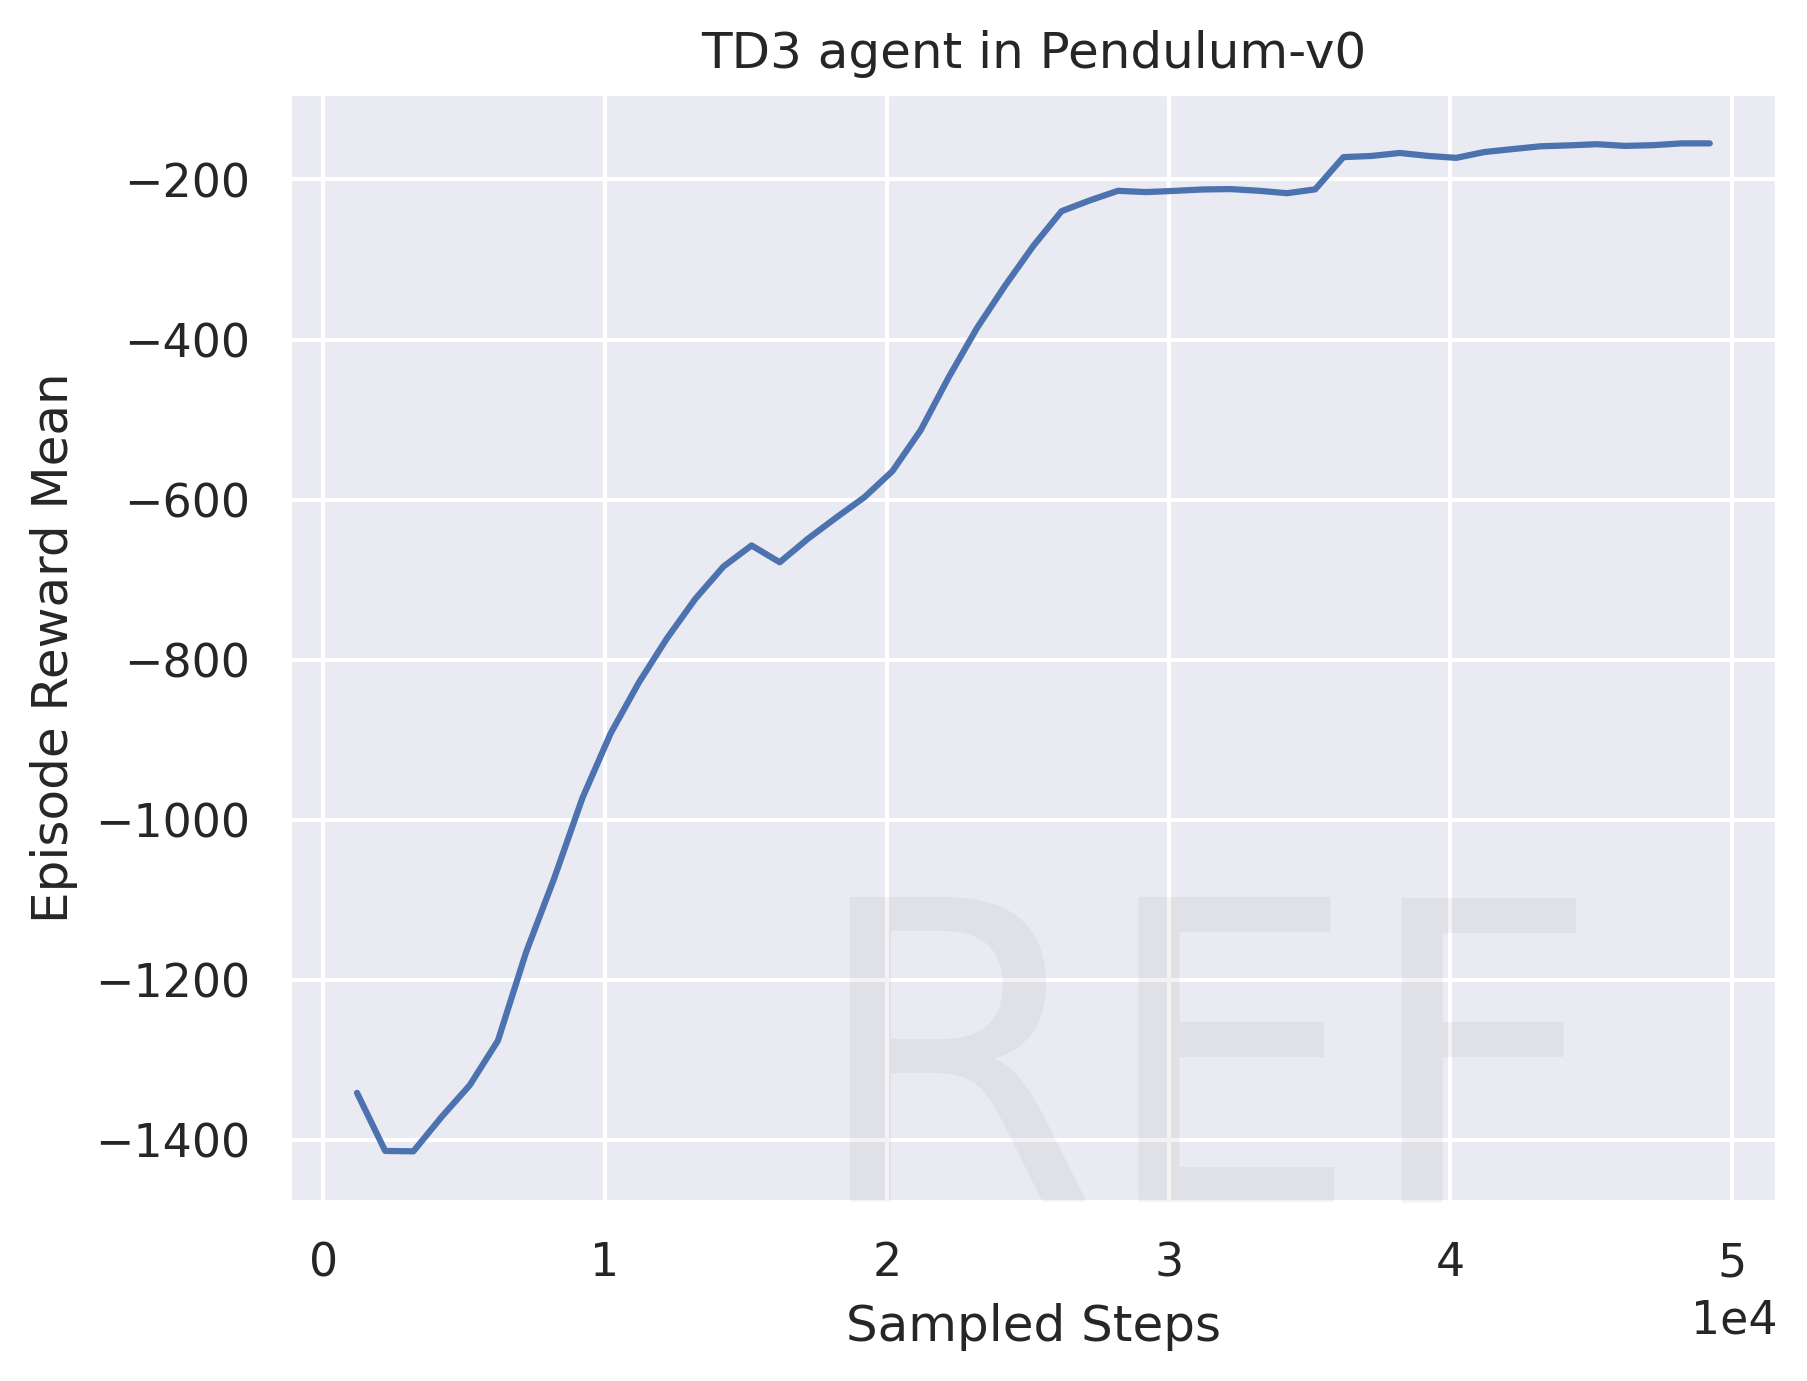

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

progress = pd.read_csv("Pendulum-v0/td3/progress.csv")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=progress,
    x="total_steps",
    y="episode_reward"
)
ax.set_title("TD3 agent in Pendulum-v0")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")

# You should remove this line in your code:
ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)

ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

plt.savefig('pendulum-td3.png', format='png', dpi=300, bbox_inches="tight")


### Demo 2.2: Train TD3 agent in MetaDrive-Tut-Easy-v0

When using default hyperparameters, I find TD3 fails to progress in this very simple environment. This might be caused by the overfitting issue --- the training data to the value network is lack of diversity, so it remembers firmly that the state values should around 0. This destroies the training of policy. To overcome this, I increase exporation noise, reduce the training batch size and also shrink the size of warmup data by decreasing `start_steps`.

In [61]:
!python train_td3.py \
--env-id MetaDrive-Tut-Easy-v0 \
--log-dir MetaDrive-Tut-Easy-v0 \
--max-steps 100000 \
--start-steps 1000 \
--batch_size 64 \
--expl_noise 0.2

/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].
Successfully registered MetaDrive environments:  ['MetaDrive-Tut-Easy-v0', 'MetaDrive-Tut-Hard-v0', 'MetaDrive-Tut-1Env-v0', 'MetaDrive-Tut-5Env-v0', 'MetaDrive-Tut-10Env-v0', 'MetaDrive-Tut-20Env-v0', 'MetaDrive-Tut-50Env-v0', 'MetaDrive-Tut-100Env-v0', 'MetaDrive-Tut-Test-v0']
===== TD3 Training Step 1004 =====:
  actor_loss: .nan
  critic_loss: 0.007964896969497204
  episode_reward: 2.5829414229855834
  frame_per_second: 1577
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 0.0
  target_q: 0.014211263507604599
  total_episodes: 

===== TD3 Training Step 21043 =====:
  actor_loss: -2.7623720169067383
  critic_loss: 0.10888376086950302
  episode_reward: 26.239921398865246
  frame_per_second: 315
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 0.02
  target_q: 2.6517069339752197
  total_episodes: 235
  total_steps: 21043
  total_time: 66.79757761955261

Trainer is saved at <MetaDrive-Tut-Easy-v0/td3>. Progress is saved at <MetaDrive-Tut-Easy-v0/td3/progress.csv>.
===== TD3 Training Step 22061 =====:
  actor_loss: -3.160027027130127
  critic_loss: 2.440919876098633
  episode_reward: 32.06637799491681
  frame_per_second: 313
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 0.05
  target_q: 2.729398488998413
  total_episodes: 246
  total_steps: 22061
  total_time: 70.27426266670227

===== TD3 Training Step 23084 =====:
  actor_loss: .nan
  critic_loss: 0.18359561264514923
  episode_reward: 33.164317664372305
  frame_per_second: 313
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 0.06
  target_q: 3.8751673698425293


===== TD3 Training Step 43044 =====:
  actor_loss: .nan
  critic_loss: 25.41677474975586
  episode_reward: 85.49082471546262
  frame_per_second: 304
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 0.38
  target_q: 22.587581634521484
  total_episodes: 455
  total_steps: 43044
  total_time: 141.28918075561523

Trainer is saved at <MetaDrive-Tut-Easy-v0/td3>. Progress is saved at <MetaDrive-Tut-Easy-v0/td3/progress.csv>.
===== TD3 Training Step 44138 =====:
  actor_loss: .nan
  critic_loss: 4.046694755554199
  episode_reward: 88.12471904151354
  frame_per_second: 304
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 0.44
  target_q: 22.453744888305664
  total_episodes: 463
  total_steps: 44138
  total_time: 144.95687580108643

===== TD3 Training Step 45109 =====:
  actor_loss: -22.80328369140625
  critic_loss: 4.910894393920898
  episode_reward: 90.73719804562025
  frame_per_second: 304
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 0.48
  target_q: 21.76107406616211
  total_episodes: 4

Trainer is saved at <MetaDrive-Tut-Easy-v0/td3>. Progress is saved at <MetaDrive-Tut-Easy-v0/td3/progress.csv>.
===== TD3 Training Step 66007 =====:
  actor_loss: -37.165000915527344
  critic_loss: 43.042884826660156
  episode_reward: 113.94736676714379
  frame_per_second: 300
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 1.0
  target_q: 37.347740173339844
  total_episodes: 617
  total_steps: 66007
  total_time: 219.65787839889526

===== TD3 Training Step 67124 =====:
  actor_loss: .nan
  critic_loss: 67.3873291015625
  episode_reward: 113.94153711139066
  frame_per_second: 300
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 1.0
  target_q: 38.90199279785156
  total_episodes: 625
  total_steps: 67124
  total_time: 223.59329652786255

Trainer is saved at <MetaDrive-Tut-Easy-v0/td3>. Progress is saved at <MetaDrive-Tut-Easy-v0/td3/progress.csv>.
===== TD3 Training Step 68099 =====:
  actor_loss: -39.491153717041016
  critic_loss: 36.02107238769531
  episode_reward: 113.9490168807334


Trainer is saved at <MetaDrive-Tut-Easy-v0/td3>. Progress is saved at <MetaDrive-Tut-Easy-v0/td3/progress.csv>.
===== TD3 Training Step 88118 =====:
  actor_loss: .nan
  critic_loss: 6.618783950805664
  episode_reward: 107.03157847610436
  frame_per_second: 297
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 0.56
  target_q: 47.74784851074219
  total_episodes: 751
  total_steps: 88118
  total_time: 296.65550565719604

===== TD3 Training Step 89123 =====:
  actor_loss: -46.68714904785156
  critic_loss: 3.395756244659424
  episode_reward: 105.91232215827416
  frame_per_second: 296
  log_dir: MetaDrive-Tut-Easy-v0
  success_rate: 0.51
  target_q: 46.88825988769531
  total_episodes: 756
  total_steps: 89123
  total_time: 300.2685878276825

Trainer is saved at <MetaDrive-Tut-Easy-v0/td3>. Progress is saved at <MetaDrive-Tut-Easy-v0/td3/progress.csv>.
===== TD3 Training Step 90128 =====:
  actor_loss: .nan
  critic_loss: 43.66324234008789
  episode_reward: 104.90999220811368
  frame_per_sec

Index(['Unnamed: 0', 'log_dir', 'frame_per_second', 'episode_reward',
       'total_steps', 'total_episodes', 'total_time', 'actor_loss',
       'critic_loss', 'target_q', 'success_rate'],
      dtype='object')


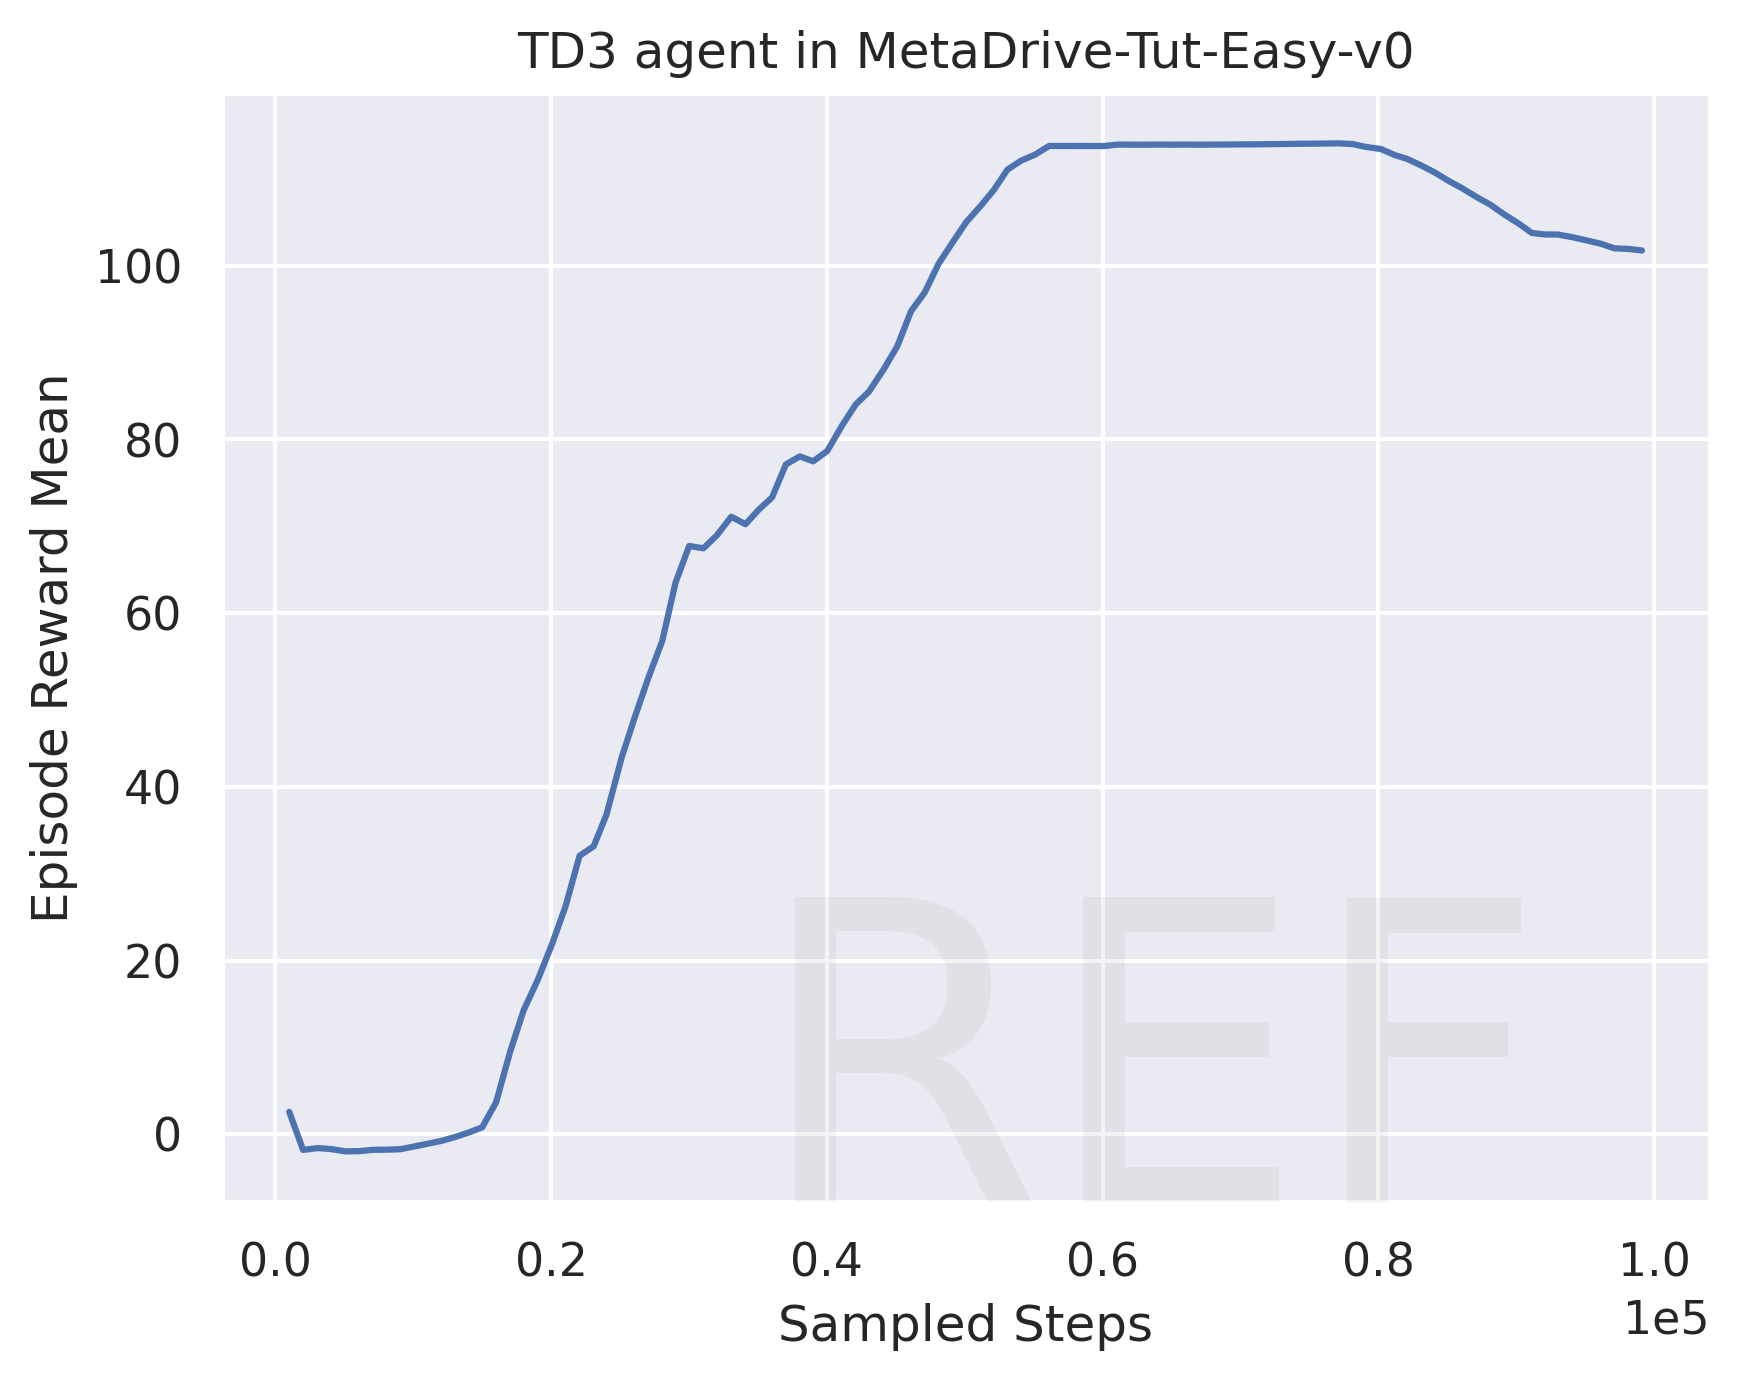

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

progress = pd.read_csv("MetaDrive-Tut-Easy-v0/td3/progress.csv")
print(progress.keys())
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=progress,
    x="total_steps",
    y="episode_reward"
)
ax.set_title("TD3 agent in MetaDrive-Tut-Easy-v0")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")

ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)

plt.savefig('metadrive-easy-td3.png', format='png', dpi=300, bbox_inches="tight")


## Demo 3: Train a PPO agent

You need to finish `core/ppo_trainer.py`, `core/buffer.py` and `train_ppo.py`.

Here we use GAE [1] (Generalized Advantage Estimation) to estimate the advantage. This technique is implemented in `PPORolloutStorage.compute_returns` in `core/buffer.py`. Concretely, we estimate the advantage of current state $t$ via:

$$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$

$$A^{GAE}_t = \sum_{l=0}^{\infty} (\gamma \lambda) ^ l \delta_{t+l}$$

wherein $V$ is the state value function, $\lambda$ is a hyper-parameter defined in `PPOConfig["gae_lambda"]`.

You can find that when $\lambda = 0$, the GAE estimates advantage in an one-step TD manner. When $\lambda = 1$, the GAE reduces to Monte Carlo Estimation of the state value. Therefore by varying the $\lambda$, we can adjust the trade-off between the accuracy of the estimation (bias) and the variance of advantage.

[1]: Schulman, John , et al. "High-Dimensional Continuous Control Using Generalized Advantage Estimation." (2015).

### Demo 3.1 Train and draw the learning curve of PPO in CartPole

In [7]:
!python train_ppo.py \
--env-id CartPole-v0 \
--log-dir CartPole-v0 \
--num-envs 10 \
--max-steps 300000

/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
train_ppo.py:130: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you spec

===== ppo Training Iteration 13 =====:
  adv_mean: -0.6487969756126404
  entropy: 0.4831315382933005
  episode_reward: 197.44
  frame_per_second: 5264
  grad_norm: 36.89877986663427
  iteration: 13
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/CartPole-v0/ppo
  policy_loss: -0.0010608351093907959
  ratio: 0.9997886248888114
  success_rate: .nan
  total_episodes: 3097
  total_loss: 74.43489042917888
  total_steps: 280000
  value_loss: 74.43595144320757

===== ppo Training Iteration 14 =====:
  adv_mean: -0.6804834008216858
  entropy: 0.48720577229291967
  episode_reward: 199.6
  frame_per_second: 5270
  grad_norm: 36.29457209782723
  iteration: 14
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/CartPole-v0/ppo
  policy_loss: -0.0015634062505948047
  ratio: 1.0002634367881678
  success_rate: .nan
  total_episodes: 3197
  total_loss: 70.03570977235452
  total_steps: 300000
  value_loss: 70.03727319179437

===== ppo Training Ite

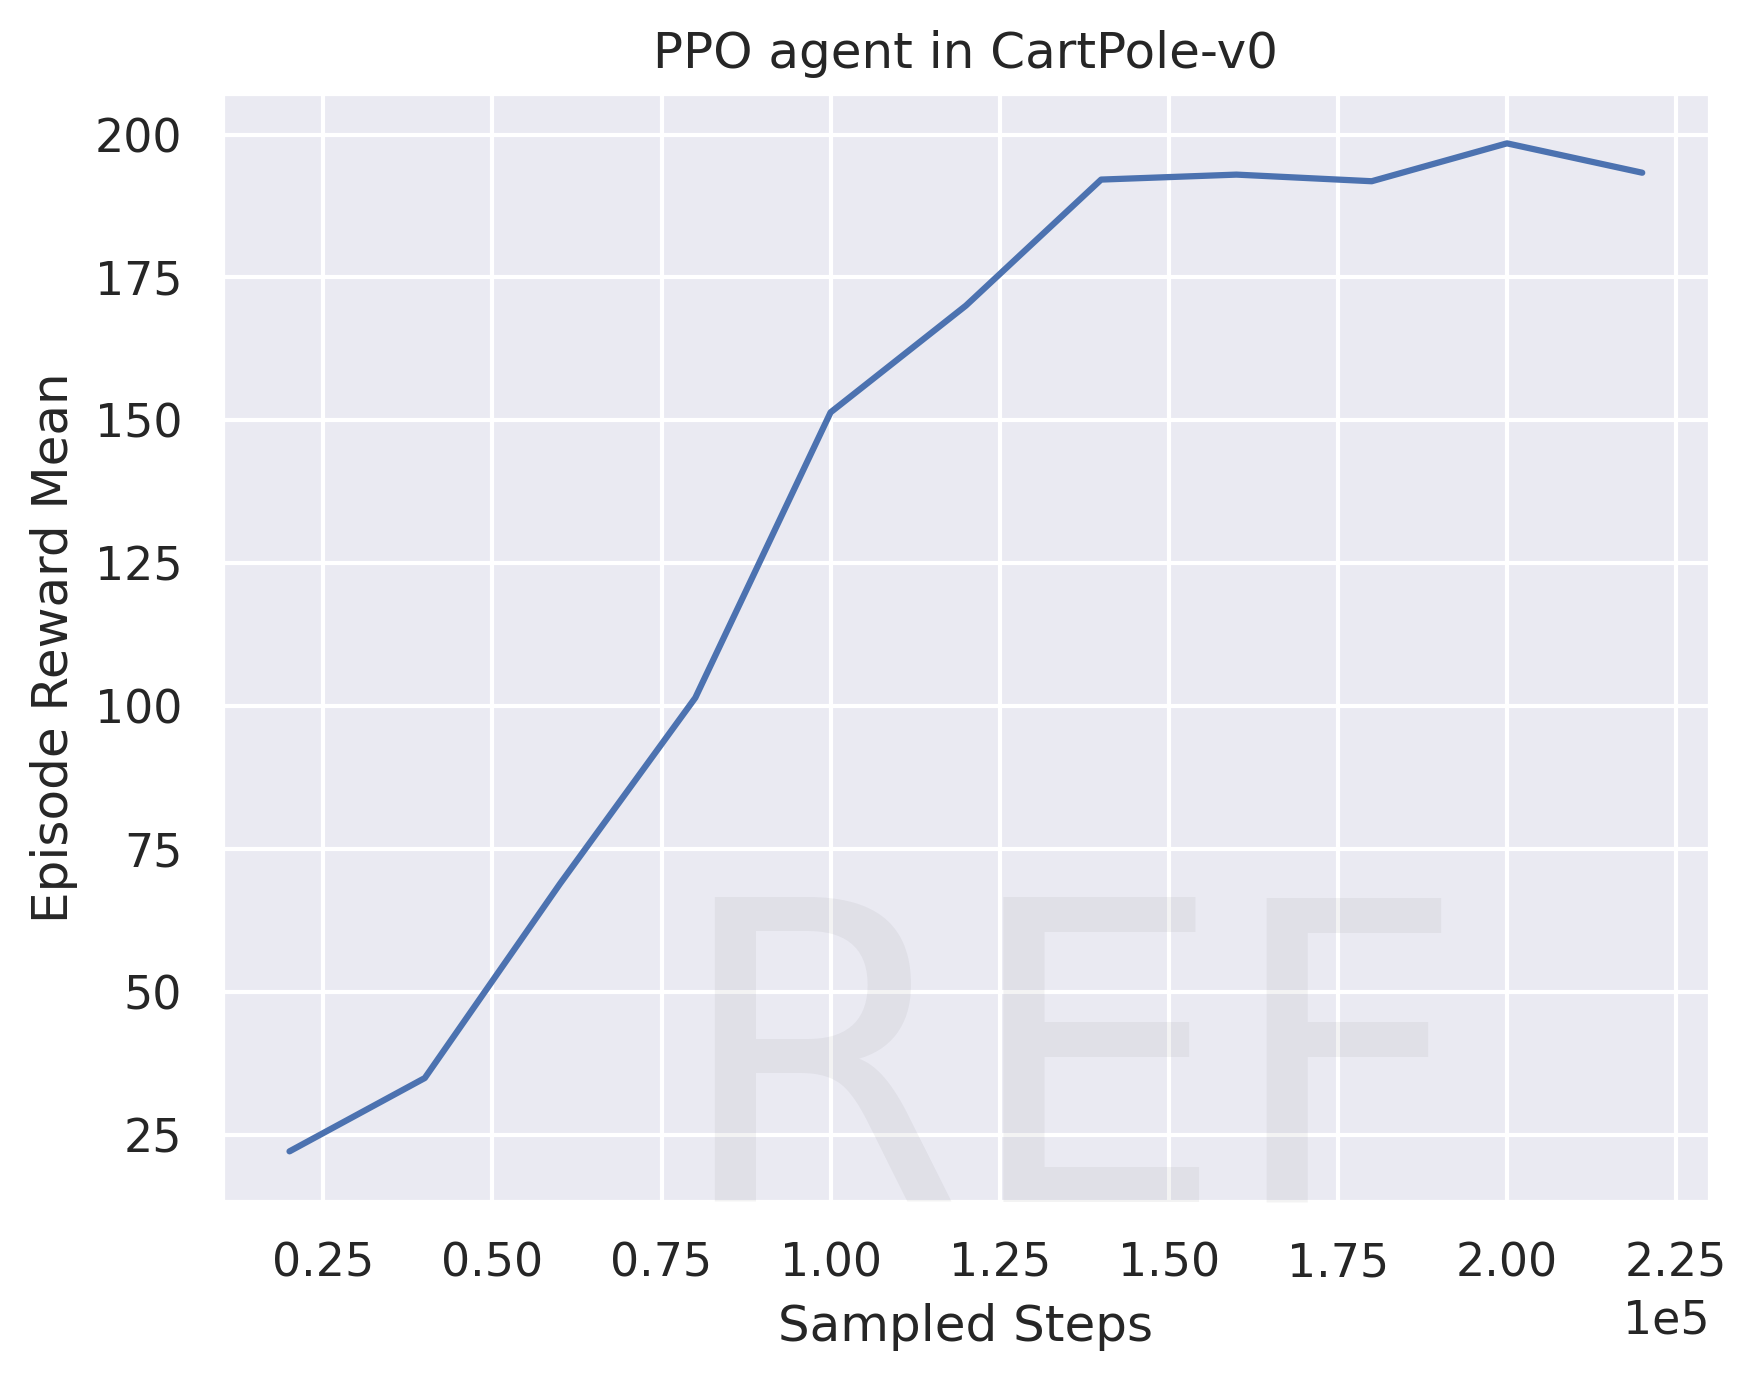

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ppo_progress = pd.read_csv("CartPole-v0/ppo/progress.csv")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=ppo_progress,
    x="total_steps",
    y="episode_reward"
)
ax.set_title("PPO agent in CartPole-v0")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")

# You should remove this line in your code:
ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)

ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

plt.savefig('cartpole-ppo.png', format='png', dpi=300, bbox_inches="tight")


### Demo 3.2: Train and play with the PPO agent in MetaDrive Easy Env.

In [3]:
!python train_ppo.py \
  --env-id MetaDrive-Tut-Easy-v0 \
  --log-dir MetaDrive-Tut-Easy-v0 \
  --num-envs 10 \
  --max-steps 500000

/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 

Trainer is saved at </home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/ppo/checkpoint-iter0.pkl>. Progress is saved at </home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/ppo/progress.csv>.
===== ppo Training Iteration 1 =====:
  adv_mean: 0.21566084027290344
  entropy: 2.7372851805809217
  episode_reward: 3.130096310938253
  frame_per_second: 2751
  grad_norm: 1.0840564608382872
  iteration: 1
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/ppo
  policy_loss: -0.01234917714385889
  ratio: 0.9998718107358003
  success_rate: 0.0
  total_episodes: 194
  total_loss: 0.03042875719480575
  total_steps: 40000
  value_loss: 0.042777934637016214

===== ppo Training Iteration 2 =====:
  adv_mean: 0.28812503814697266
  entropy: 2.6454785698499435
  episode_reward: 4.689790768090227
  frame_per_second: 2706
  grad_norm: 1.439098942757417
  iteration: 2
  log_dir: /home/

===== ppo Training Iteration 17 =====:
  adv_mean: 4.2346673011779785
  entropy: 1.6098111618787814
  episode_reward: 104.88475403321274
  frame_per_second: 1868
  grad_norm: 55.803986104940755
  iteration: 17
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/ppo
  policy_loss: -0.0014977102320139798
  ratio: 1.0007786305286945
  success_rate: 0.81
  total_episodes: 2178
  total_loss: 13.506682292009012
  total_steps: 360000
  value_loss: 13.508180074814039

===== ppo Training Iteration 18 =====:
  adv_mean: 3.995670795440674
  entropy: 1.4993204812208811
  episode_reward: 110.08866207440742
  frame_per_second: 1891
  grad_norm: 84.81759700408348
  iteration: 18
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/ppo
  policy_loss: 0.0003901892887929884
  ratio: 0.9997481256723404
  success_rate: 0.91
  total_episodes: 2311
  total_loss: 14.398023452514257
  total_steps: 380000
  value_los

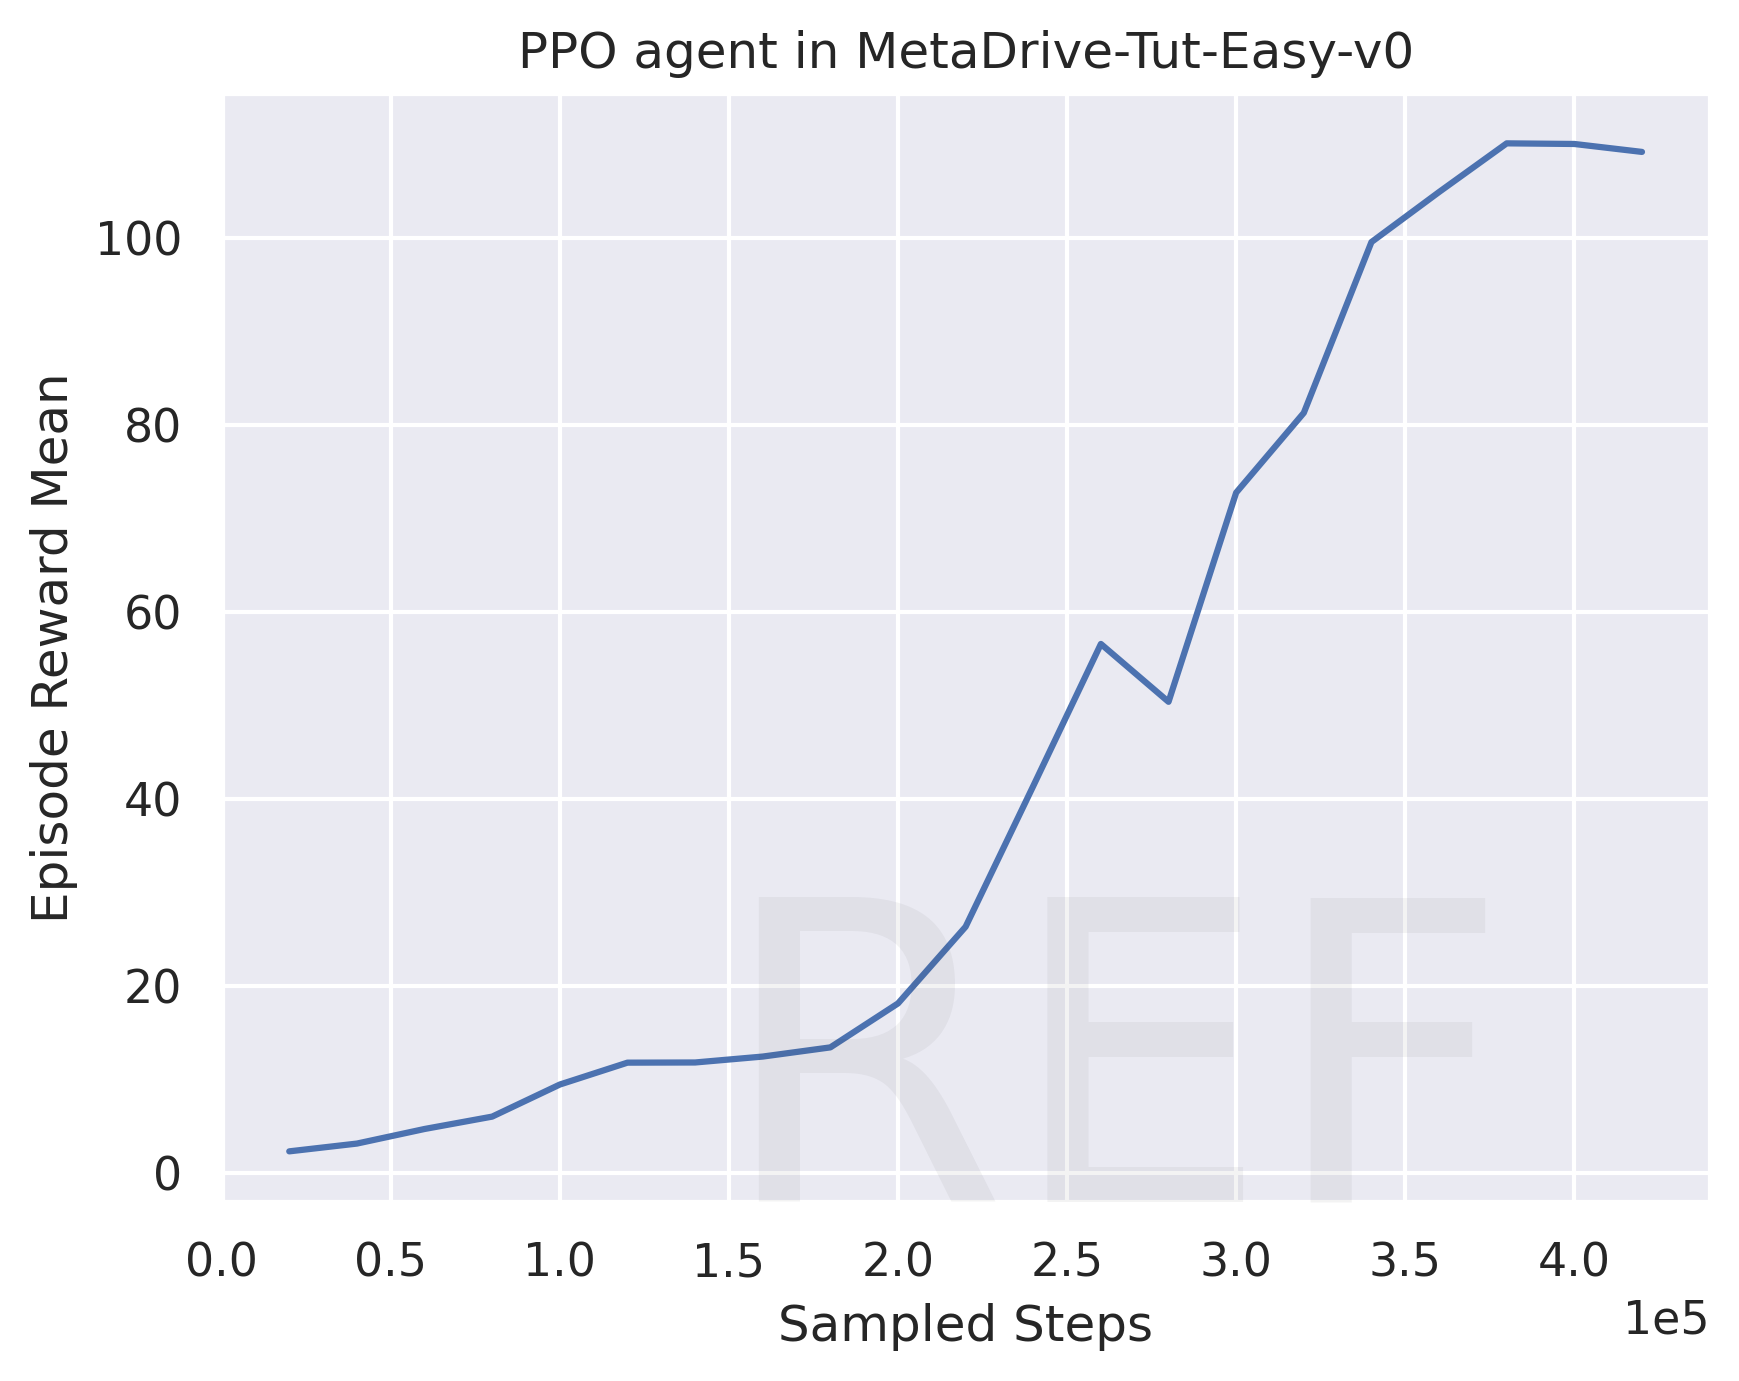

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ppo_progress = pd.read_csv("MetaDrive-Tut-Easy-v0/ppo/progress.csv")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=ppo_progress,
    x="total_steps",
    y="episode_reward"
)
ax.set_title("PPO agent in MetaDrive-Tut-Easy-v0")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")

ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)

plt.savefig('metadrive-easy-ppo.png', format='png', dpi=300, bbox_inches="tight")


### Visualize the performance of PPO in MetaDrive Easy Env.

/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].
Successfully registered MetaDrive environments:  ['MetaDrive-Tut-Easy-v0', 'MetaDrive-Tut-Hard-v0', 'MetaDrive-Tut-1Env-v0', 'MetaDrive-Tut-5Env-v0', 'MetaDrive-Tut-10Env-v0', 'MetaDrive-Tut-20Env-v0', 'MetaDrive-Tut-50Env-v0', 'MetaDrive-Tut-100Env-v0', 'MetaDrive-Tut-Test-v0']
Successfully load weights from /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/ppo/checkpoint-final.pkl!
Evaluating 1/1 episodes. We are in 1/1000 steps. Current episode reward: 0.000
Evaluating 1/1 episodes. We are in 51/1000 steps. Current episode reward: 6.183
Evaluating 1/1 episodes.

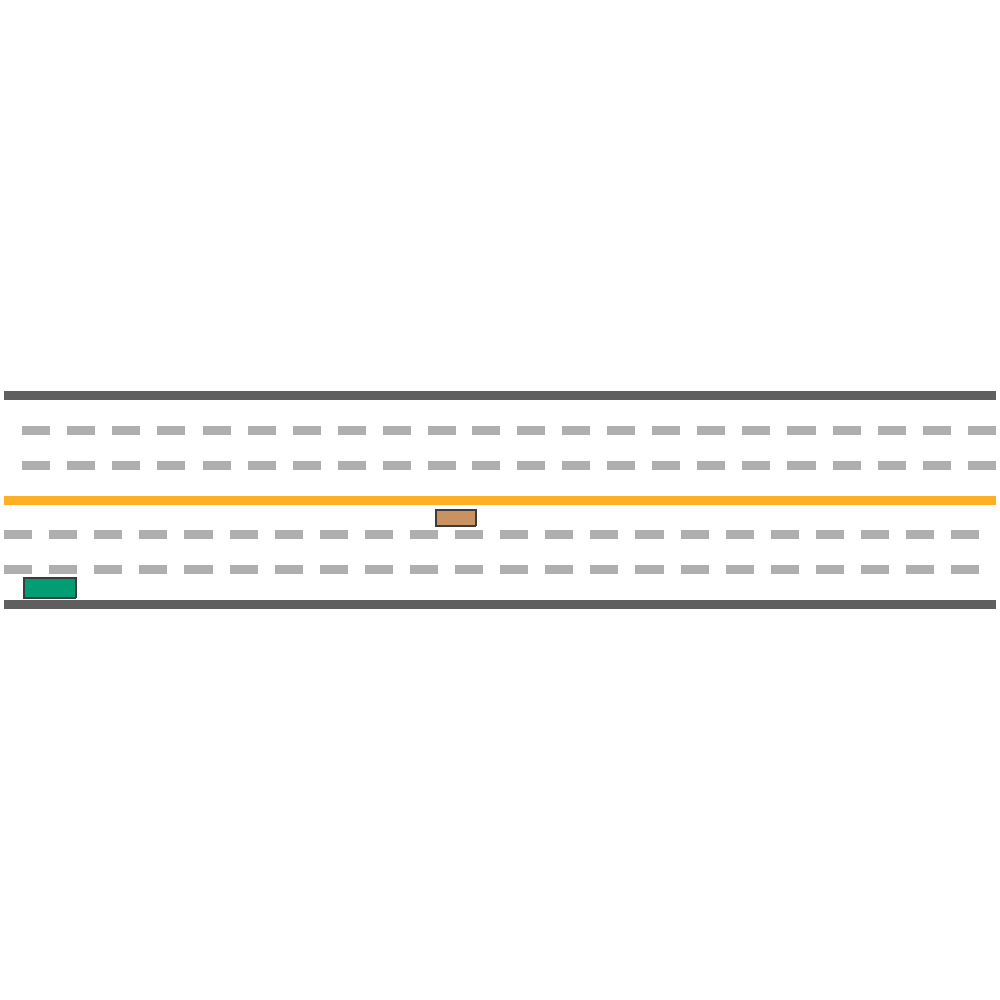

PPO agent achieves 93.56323231922725 return in MetaDrive Easy environment.


In [1]:
# Load the agent using PolicyAPI (easy to use interface to get policy)

from core.envs import make_envs
import gym
from vis import PPOPolicy, evaluate, animate
import pygame

env_name = "MetaDrive-Tut-Easy-v0"
policy = PPOPolicy(
    env_name,  # In order to get the observation shape
    num_envs=1, 
    log_dir="MetaDrive-Tut-Easy-v0/ppo/",
    suffix="final"
)


# Render the learned behavior
# NOTE: The learned agent is marked by green color.
eval_reward, eval_info = evaluate(
    policy=policy, 
    num_episodes=1, 
    env_name=env_name,
    render="topdown",  # Visualize the behaviors in top-down view
    verbose=True
)

frames = [pygame.surfarray.array3d(f).swapaxes(0, 1) for f in eval_info["frames"]]

animate(frames, duration=0.01)

print("PPO agent achieves {} return in MetaDrive Easy environment.".format(eval_reward))

## Demo 4: GAIL agent

In [11]:
!python train_gail.py \
  --env-id MetaDrive-Tut-Easy-v0 \
  --log-dir MetaDrive-Tut-Easy-v0 \
  --num-envs 10 \
  --max-steps 1000000 \
  --expert-dataset-size 30000

/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/core
/home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fal

Generated 1000/30000 steps from the expert. Average episode reward: 112.570, success rate: 0.950
Generated 2000/30000 steps from the expert. Average episode reward: 112.811, success rate: 0.962
Generated 3000/30000 steps from the expert. Average episode reward: 112.660, success rate: 0.954
Generated 30000 steps from the expert. Average episode reward: 112.660, success rate: 0.954
Start training!
===== gail Training Iteration 0 =====:
  adv_mean: 0.0
  discriminator_loss: 0.4790880781192428
  entropy: 2.765247808664273
  episode_reward: 2.4261104633809234
  frame_per_second: 1592
  gail_reward: 0.027426237079243247
  grad_norm: 1.4316197511477349
  iteration: 0
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/gail
  policy_loss: -0.031809635761265574
  ratio: 1.0017187595367432
  success_rate: 0.0
  total_episodes: 92
  total_loss: -0.03180963567290933
  total_steps: 20000
  total_time: 12.557895183563232

Trainer is saved at </home/zhe

===== gail Training Iteration 13 =====:
  adv_mean: 0.0
  discriminator_loss: 0.19595882970935258
  entropy: 1.1248853119520041
  episode_reward: 7.676452130433116
  frame_per_second: 1388
  gail_reward: 0.0724622287381536
  grad_norm: 1.5785549662052056
  iteration: 13
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/gail
  policy_loss: -0.07326427114028962
  ratio: 1.0025797613156147
  success_rate: 0.02
  total_episodes: 3759
  total_loss: -0.07326427135043419
  total_steps: 280000
  total_time: 201.65575051307678

===== gail Training Iteration 14 =====:
  adv_mean: 0.0
  discriminator_loss: 0.24568411042101873
  entropy: 0.9952759670905578
  episode_reward: 13.817004787445223
  frame_per_second: 1381
  gail_reward: 0.0604698611709934
  grad_norm: 2.9951892825273365
  iteration: 14
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/gail
  policy_loss: -0.06071585297393493
  ratio: 1.0

===== gail Training Iteration 27 =====:
  adv_mean: 0.0
  discriminator_loss: 0.19385843986693102
  entropy: 0.05587788589316635
  episode_reward: 84.43653706723217
  frame_per_second: 1373
  gail_reward: 0.04507684771162577
  grad_norm: 9.075339367450812
  iteration: 27
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/gail
  policy_loss: -0.04548224314856224
  ratio: 1.0006618252931496
  success_rate: 0.27
  total_episodes: 7397
  total_loss: -0.045482243368258846
  total_steps: 560000
  total_time: 407.7357499599457

===== gail Training Iteration 28 =====:
  adv_mean: 0.0
  discriminator_loss: 0.19198116545493787
  entropy: 0.04029166120886564
  episode_reward: 88.04055147603833
  frame_per_second: 1373
  gail_reward: 0.06202299406226629
  grad_norm: 5.058152504456349
  iteration: 28
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/gail
  policy_loss: -0.06215852314176468
  ratio: 1.

===== gail Training Iteration 41 =====:
  adv_mean: 0.0
  discriminator_loss: 0.29213373128038184
  entropy: 0.024338371103975732
  episode_reward: 111.8366344907218
  frame_per_second: 1376
  gail_reward: 0.060472841307711904
  grad_norm: 3.8530718540533995
  iteration: 41
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/gail
  policy_loss: -0.0606514491331883
  ratio: 0.9997712726776417
  success_rate: 0.94
  total_episodes: 9979
  total_loss: -0.0606514491713964
  total_steps: 840000
  total_time: 610.3583798408508

===== gail Training Iteration 42 =====:
  adv_mean: 0.0
  discriminator_loss: 0.3033753021596334
  entropy: 0.013534459330213185
  episode_reward: 110.85057790428556
  frame_per_second: 1376
  gail_reward: 0.09192159287631511
  grad_norm: 3.7352602616334574
  iteration: 42
  log_dir: /home/zhenghao/CS269/cs269-2022fall-workshop/assignment3(2022fall)/MetaDrive-Tut-Easy-v0/gail
  policy_loss: -0.0914330980143486
  ratio: 1

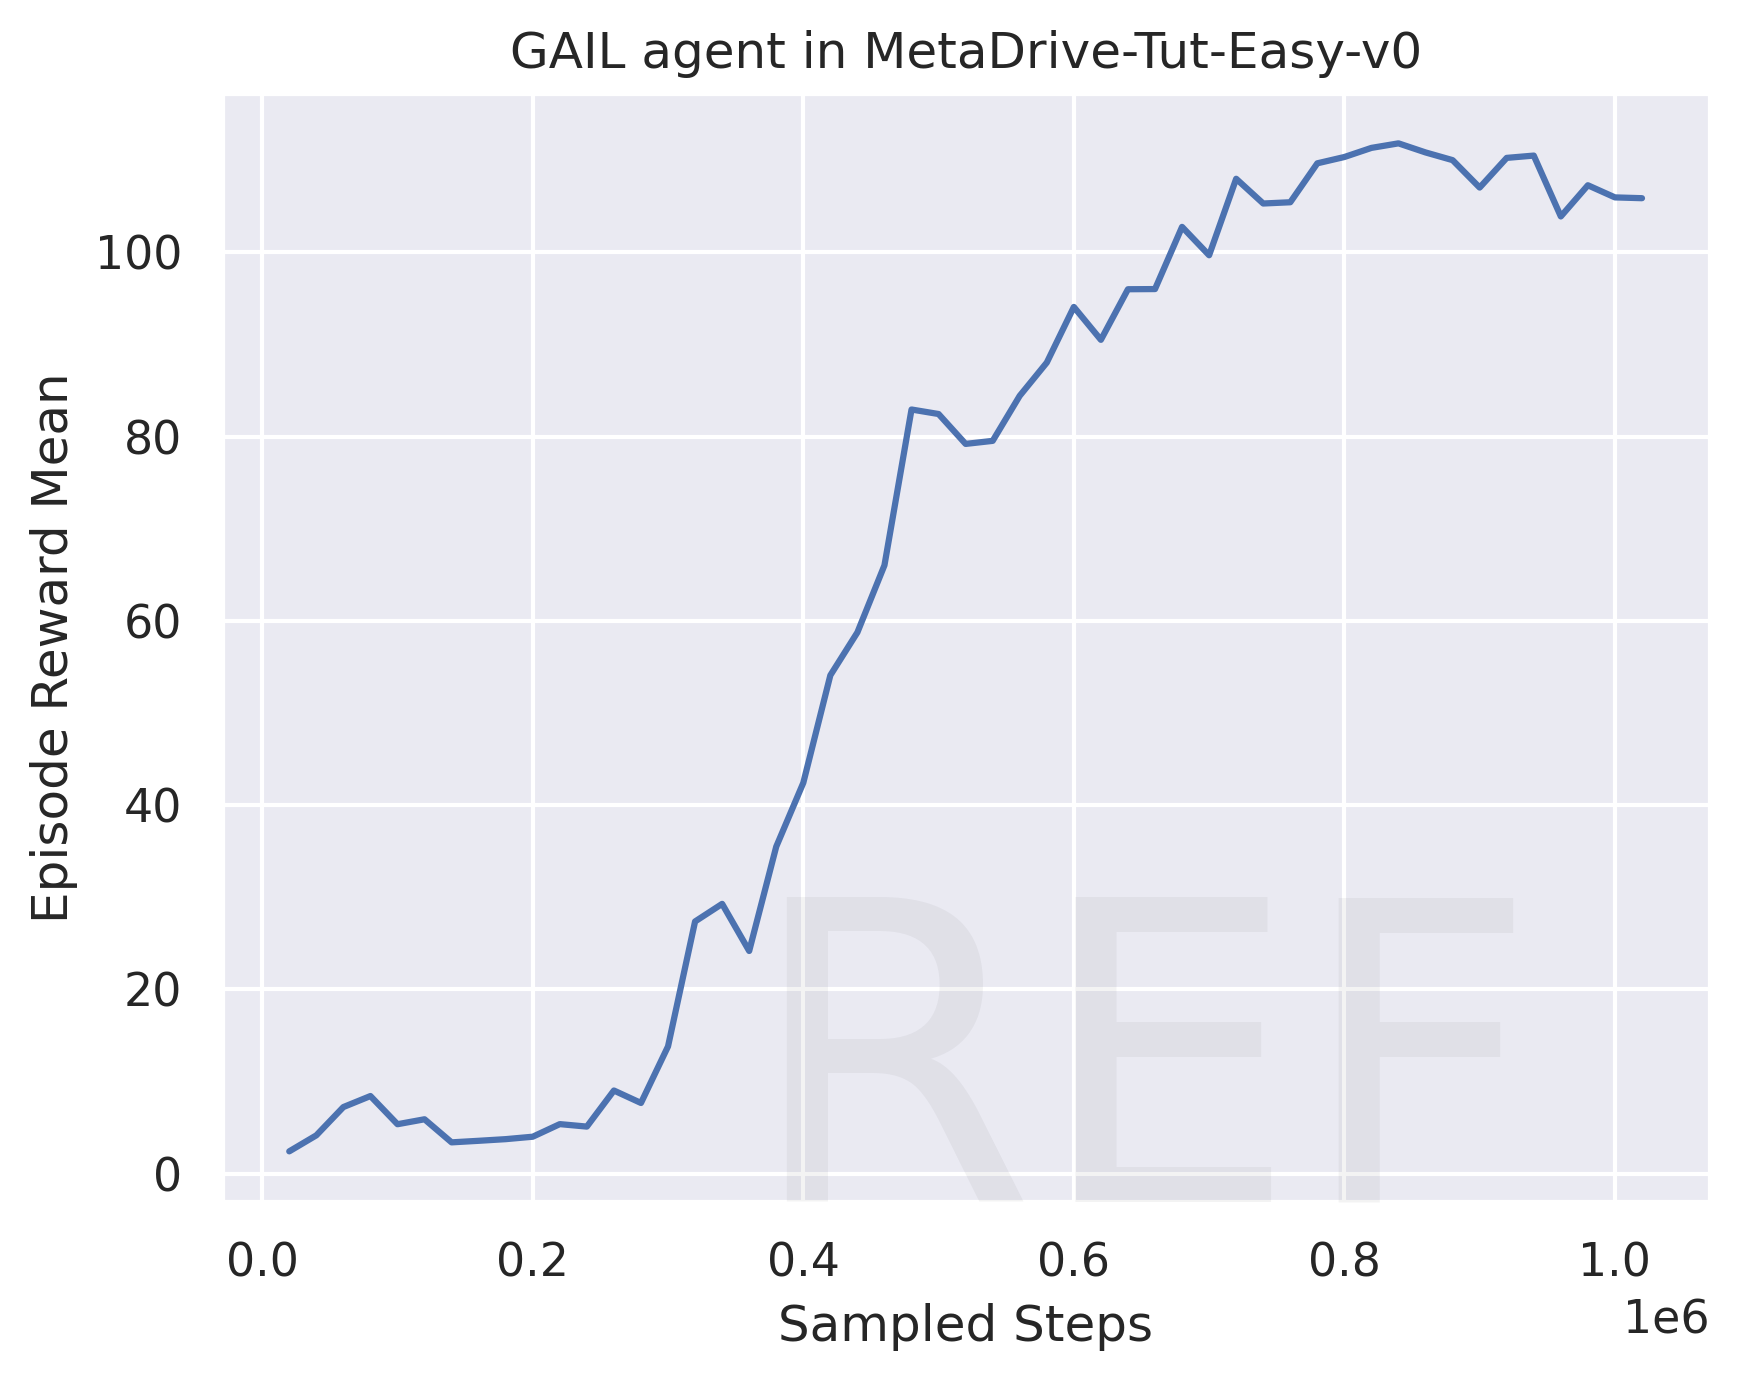

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ppo_progress = pd.read_csv("MetaDrive-Tut-Easy-v0/gail/progress.csv")
plt.figure(dpi=300)
sns.set("notebook", "darkgrid")
ax = sns.lineplot(
    data=ppo_progress,
    x="total_steps",
    y="episode_reward"
)
ax.set_title("GAIL agent in MetaDrive-Tut-Easy-v0")
ax.set_ylabel("Episode Reward Mean")
ax.set_xlabel("Sampled Steps")

ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)

plt.savefig('metadrive-easy-gail.png', format='png', dpi=300, bbox_inches="tight")


## Demo 5: Generalization Experiments

Here we draw the figures of generalization experiments. You can always find that when training in the environment with only one sceanrio, the test performance is poor.

Due to computing resource limit, we do not require you to repeat the experiments for multiple time. This leads to huge instability in the performance. As you can see, in TD3 generalization experiments, when training with 20 traffic sceanrios, the training and test performance both drop. Repeating multiple times of experiments with different random seeds can relieve this issue.

We provide `train_[ppo|gail|td3].py`, `eval_[ppo|gail|td3].py`, `[ppo|gail|td3]_generalization_train.sh` and `[ppo|gail|td3]_generalization_eval.sh`. You can refer to them for more information.

You only need to pick one algorithm and run the generalization experiments. See `result.md` for more details.


References:

The Figure 8 in [MetaDrive paper](https://arxiv.org/pdf/2109.12674.pdf).

The Figure 2 in [ProcGen paper](http://proceedings.mlr.press/v97/cobbe19a/cobbe19a.pdf).



Text(34.983333333333334, 167.25650970900836, 'REF')

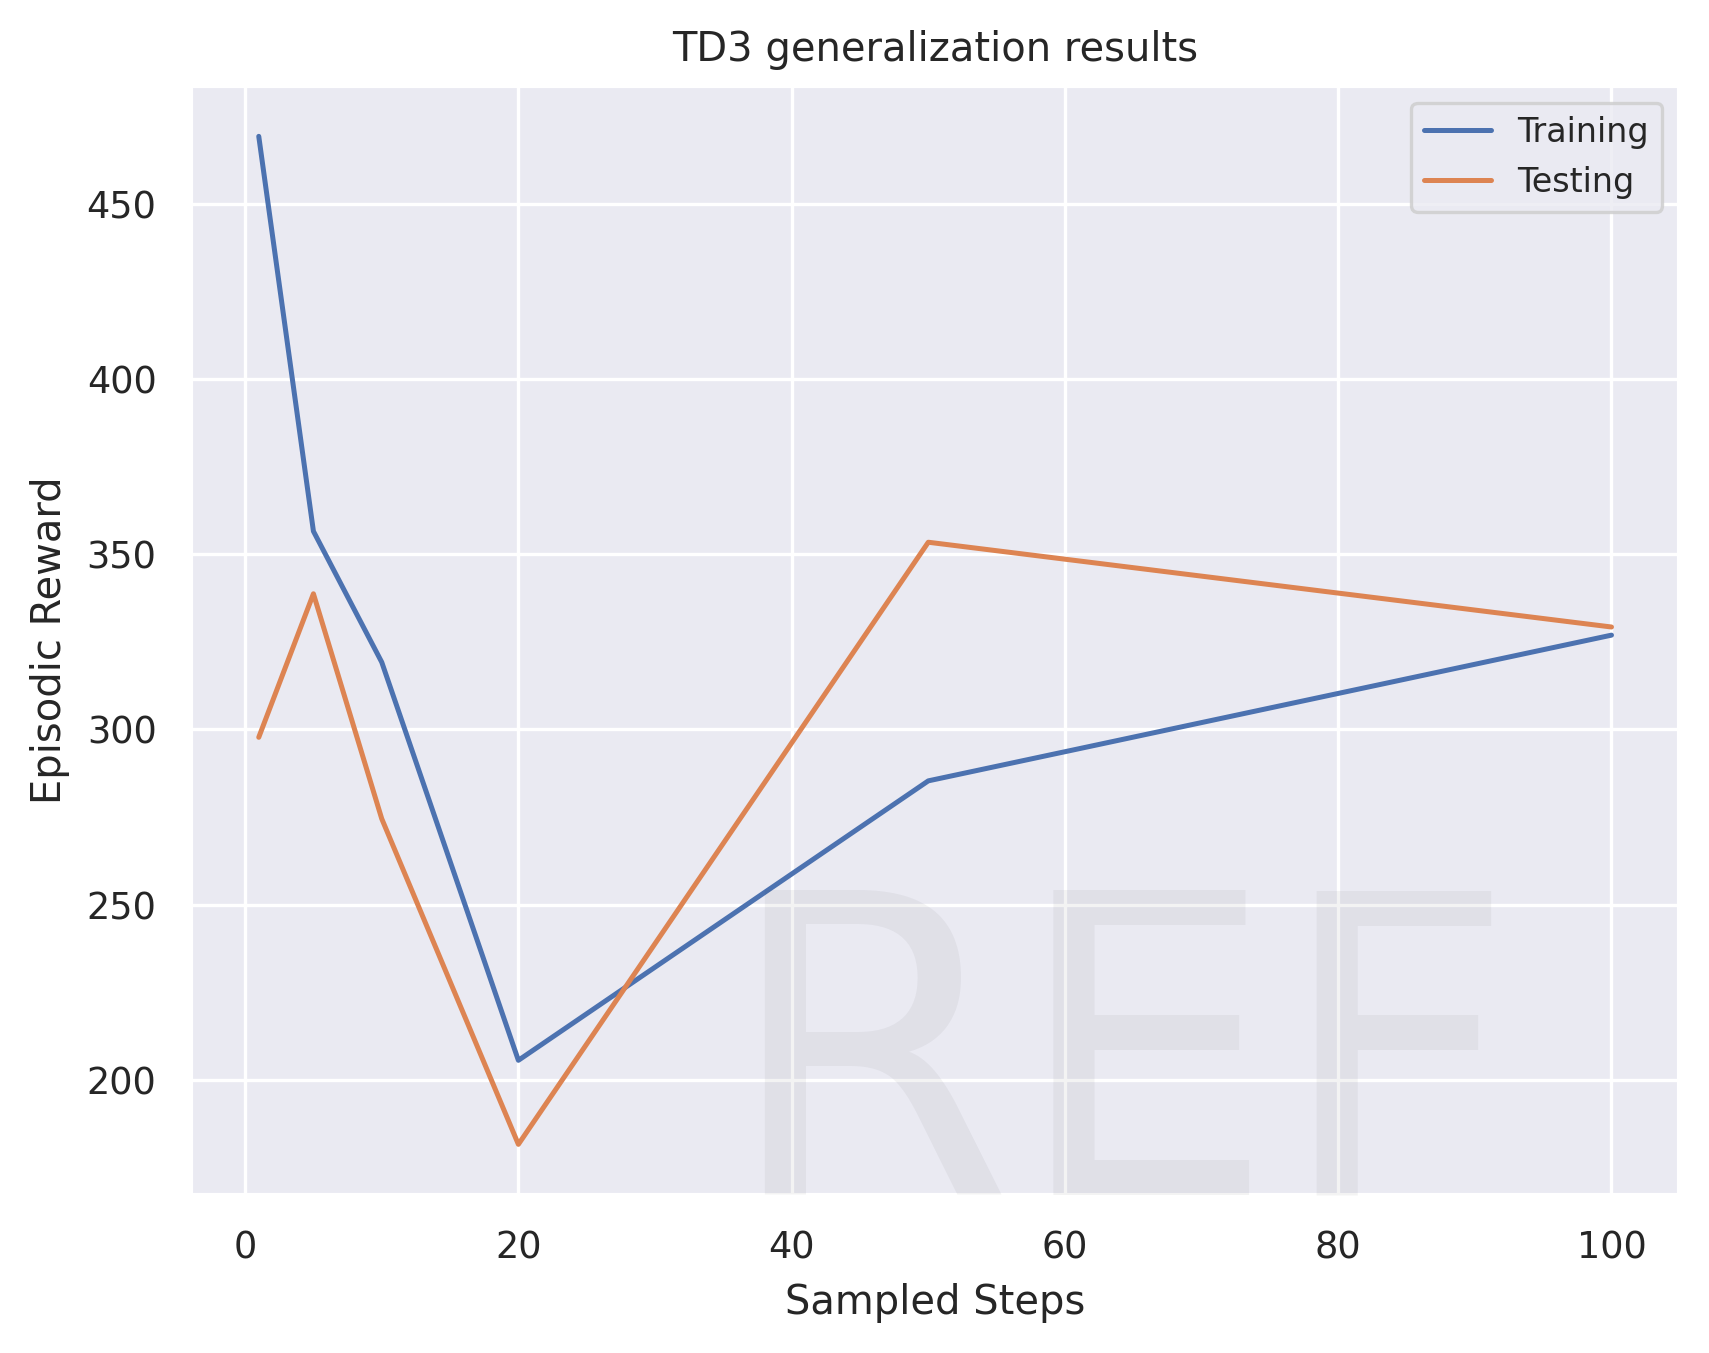

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

y="training_episode_reward/episode_reward_mean"
# y="success_rate/success_rate_mean"
# y="learning_stats/entropy"
# y = "total_episodes"


plot_data = []

for env_num in [1, 5, 10, 20, 50, 100]:
    df = pd.read_csv("MetaDrive-Tut-{}Env-v0/td3/progress.csv".format(env_num))
    
    plot_data.append(dict(
        value=df.iloc[-1]["episode_reward"],
        env_num=env_num,
        label="Training"
    ))
    
    eval_df = pd.read_csv("MetaDrive-Tut-{}Env-v0/td3/eval_results.csv".format(env_num))
    
    plot_data.append(dict(
        value=eval_df["rewards"].mean(),
        env_num=env_num,
        label="Testing"
    ))
plot_data = pd.DataFrame(plot_data)
    

# df = pd.concat(dfs)
# df = df.reset_index()

plt.figure(dpi=300)
sns.set("paper", "darkgrid")
ax = sns.lineplot(
    data=plot_data,
    hue="label",
    x="env_num",
    y="value"
)
ax.set_title("TD3 generalization results")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Sampled Steps")
# ax.set_xlim(0, 1.1e6)
# ax.set_ylim(0, 8)
ax.legend(fontsize=8, loc="upper right")
ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)



# # Note: The following figure is for reference used only, you don't have to repreduce it.

Text(34.983333333333334, 91.93084606603081, 'REF')

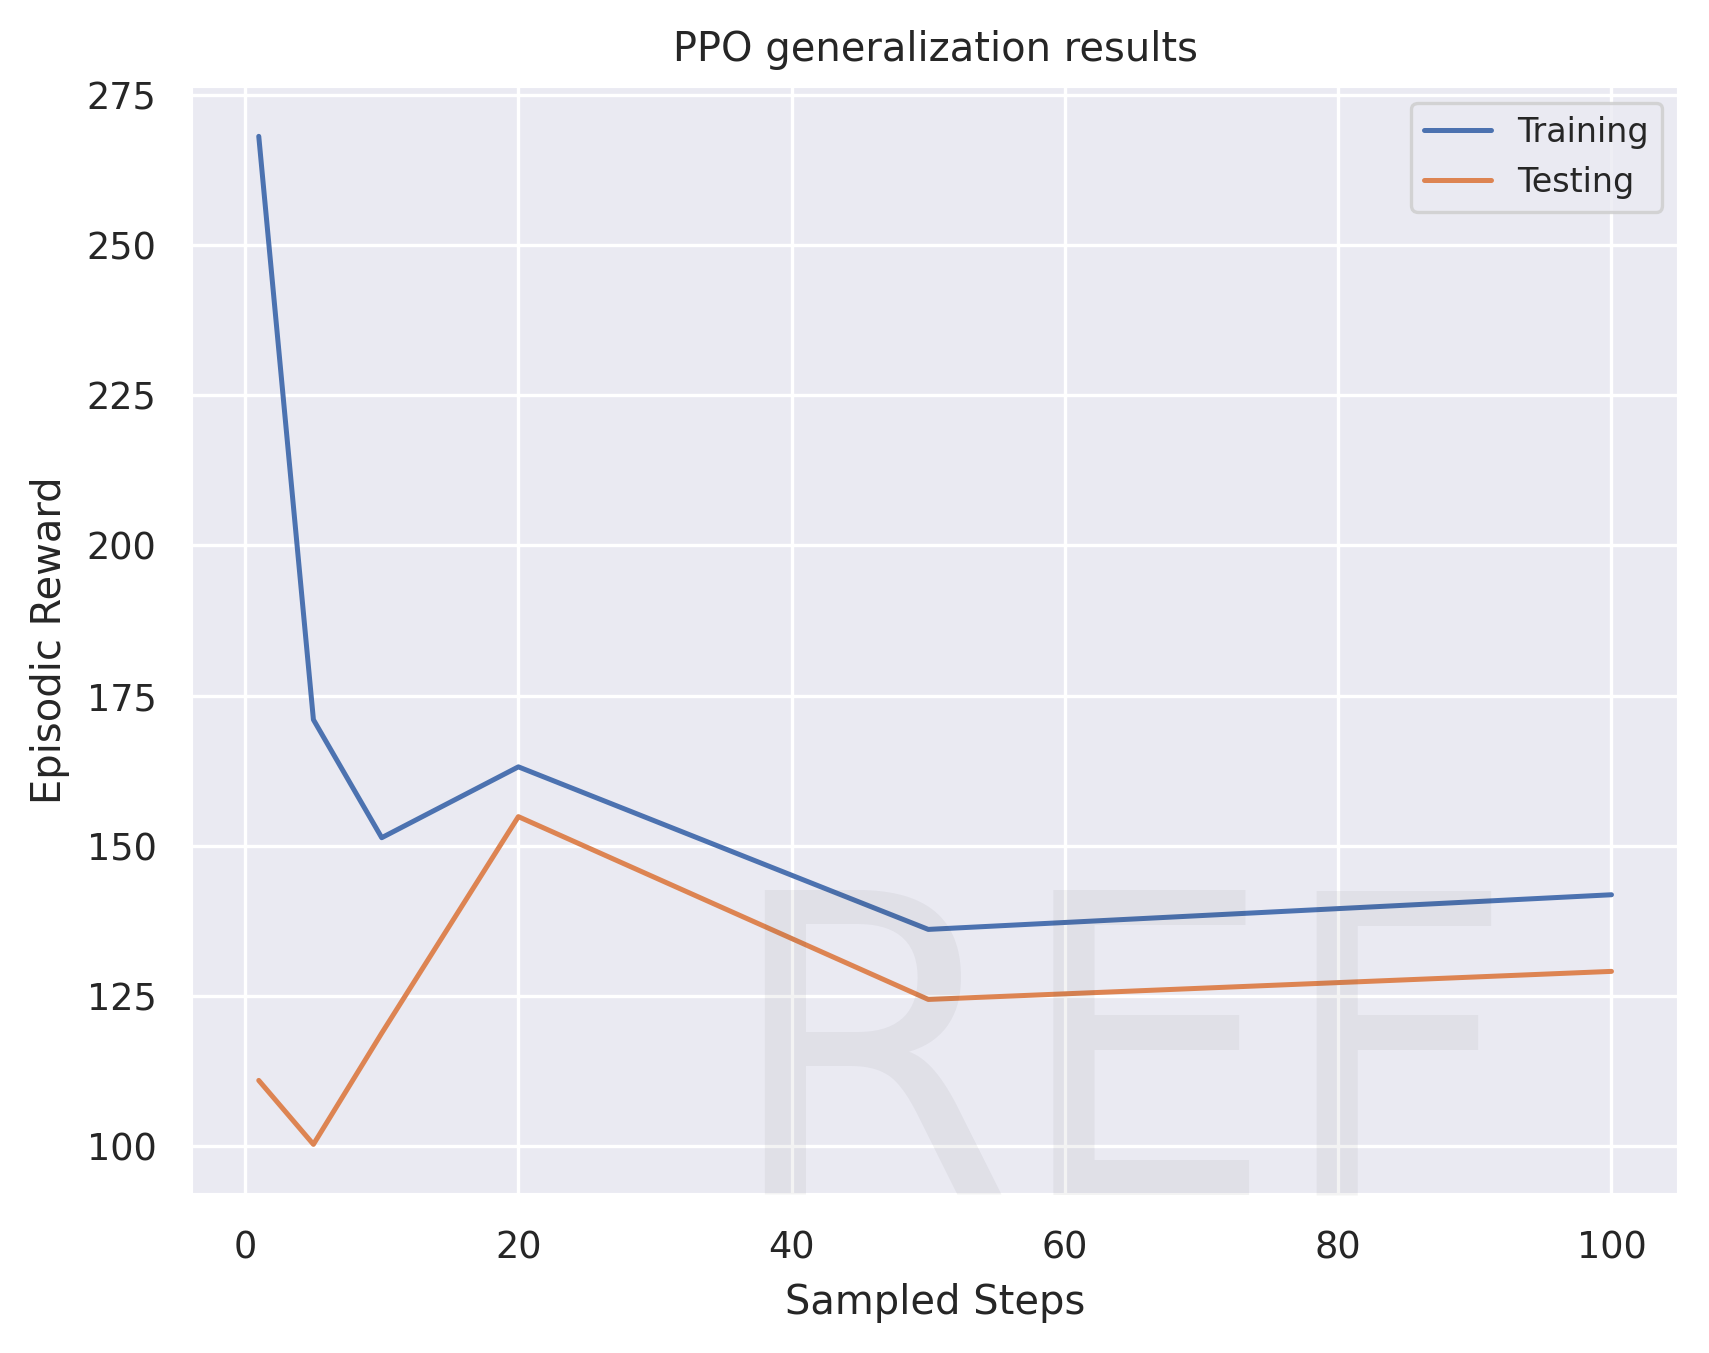

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

y="training_episode_reward/episode_reward_mean"
# y="success_rate/success_rate_mean"
# y="learning_stats/entropy"
# y = "total_episodes"


plot_data = []

for env_num in [1, 5, 10, 20, 50, 100]:
    df = pd.read_csv("MetaDrive-Tut-{}Env-v0/ppo/progress.csv".format(env_num))
    
    plot_data.append(dict(
        value=df.iloc[-1]["episode_reward"],
        env_num=env_num,
        label="Training"
    ))
    
    eval_df = pd.read_csv("MetaDrive-Tut-{}Env-v0/ppo/eval_results.csv".format(env_num))
    
    plot_data.append(dict(
        value=eval_df["rewards"].mean(),
        env_num=env_num,
        label="Testing"
    ))
plot_data = pd.DataFrame(plot_data)
    

# df = pd.concat(dfs)
# df = df.reset_index()

plt.figure(dpi=300)
sns.set("paper", "darkgrid")
ax = sns.lineplot(
    data=plot_data,
    hue="label",
    x="env_num",
    y="value"
)
ax.set_title("PPO generalization results")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Sampled Steps")
ax.set_yscale('log')
# ax.set_xlim(0, 1.1e6)
# ax.set_ylim(0, 8)
ax.legend(fontsize=8, loc="upper right")
ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)



# # Note: The following figure is for reference used only, you don't have to repreduce it.

Text(34.983333333333334, 37.12063339621031, 'REF')

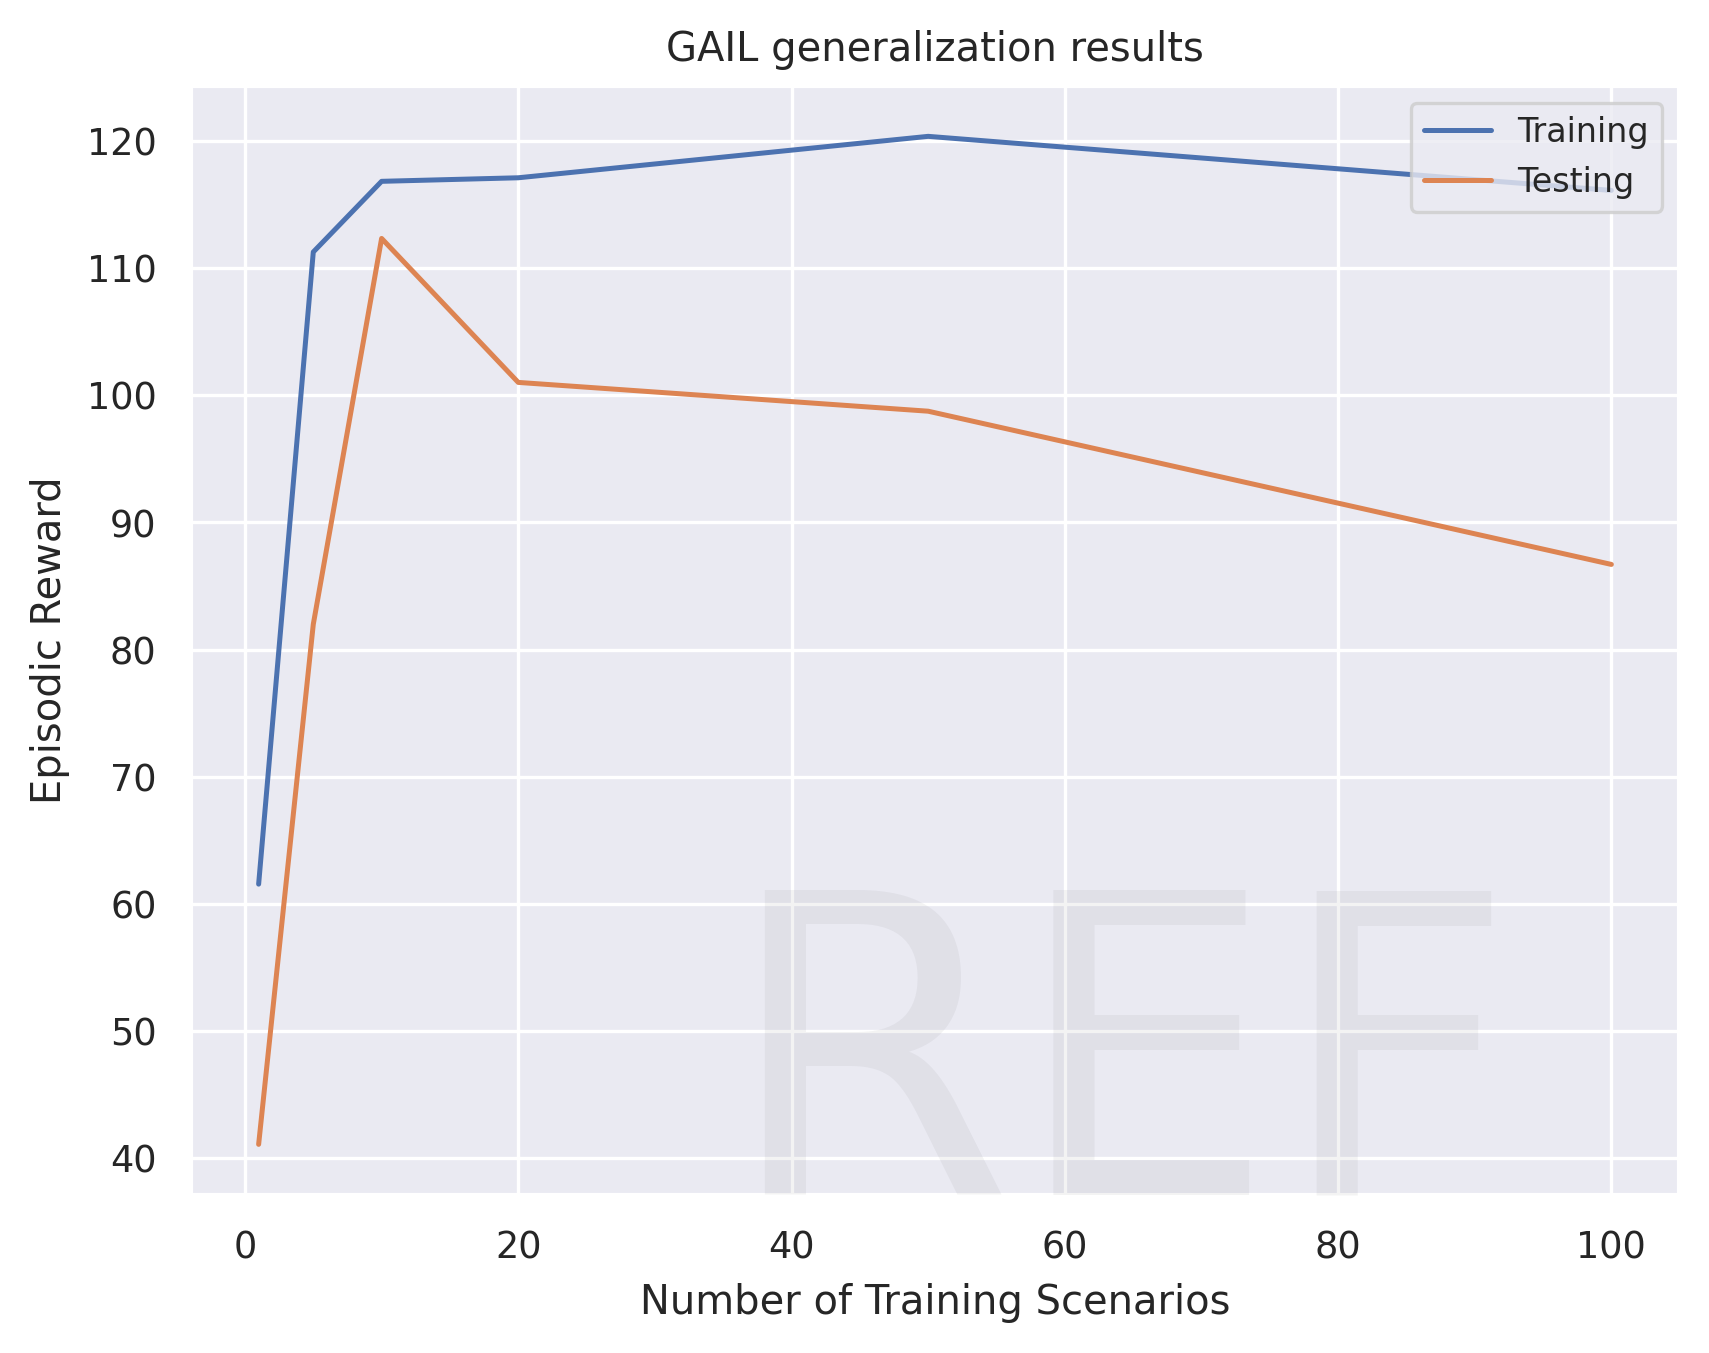

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

y="training_episode_reward/episode_reward_mean"
# y="success_rate/success_rate_mean"
# y="learning_stats/entropy"
# y = "total_episodes"


plot_data = []

for env_num in [1, 5, 10, 20, 50, 100]:
    df = pd.read_csv("MetaDrive-Tut-{}Env-v0/gail/progress.csv".format(env_num))
    
    plot_data.append(dict(
        value=df.iloc[-1]["episode_reward"],
        env_num=env_num,
        label="Training"
    ))
    
    eval_df = pd.read_csv("MetaDrive-Tut-{}Env-v0/gail/eval_results.csv".format(env_num))
    
    plot_data.append(dict(
        value=eval_df["rewards"].mean(),
        env_num=env_num,
        label="Testing"
    ))
plot_data = pd.DataFrame(plot_data)
    

# df = pd.concat(dfs)
# df = df.reset_index()

plt.figure(dpi=300)
sns.set("paper", "darkgrid")
ax = sns.lineplot(
    data=plot_data,
    hue="label",
    x="env_num",
    y="value"
)
ax.set_title("GAIL generalization results")
ax.set_ylabel("Episodic Reward")
ax.set_xlabel("Number of Training Scenarios")
# ax.set_xlim(0, 1.1e6)
# ax.set_ylim(0, 8)
ax.legend(fontsize=8, loc="upper right")
ax.annotate("REF", (ax.get_xlim()[1] / 3, ax.get_ylim()[0]), size=100, alpha=0.05)



# # Note: The following figure is for reference used only, you don't have to repreduce it.